In [1]:
from wikimapper import WikiMapper
lang = 'nl'
wm = WikiMapper(f'wiki/{lang}wiki-20220301/index_{lang}wiki-20220301.db')

In [142]:
score_file = 'wiki/nlwiki-20220301/count.min2.clean50000k2.json'
scores = json.load(open(score_file))
for s, ec in list(scores.items())[:10]:
    print(s, {wm.id_to_titles(f'Q{e}')[0]:c for e,c in ec.items()})

gemeente {'Gemeente_(bestuur)': 26776, 'Duitse_gemeente': 5021}
voetballer {'Voetballer': 5811, 'Betaald_voetbal': 4928}
china {'China': 7122, 'Volksrepubliek_China': 6408}
duits {'Duitsland': 15373, 'Duits': 6377}
groningen {'Groningen_(stad)': 10368, 'Groningen_(provincie)': 4221}
water {'Oppervlaktewater': 6708, 'Water': 4031}
wielrenner {'Wielrenner': 4894, 'Wegwielrennen': 3449}
engels {'Engels': 15768, 'Engeland': 3102}
russisch {'Russisch': 22069, 'Rusland': 2787}
frans {'Franse': 15465, 'Frans': 2291}


In [9]:
# Load text data
import json, tqdm, glob
from minimel import normalize
inglob = 'wiki/nlwiki-20220301/nlwiki-20220301-paragraph-links/*.tsv'
surface_text = {}
for g in tqdm.tqdm(glob.glob(inglob)):
    for line in open(g):
        page, links, paragraph = line.strip().split("\t", 2)
        links = json.loads(links)
        for l, e in links.items():
            for n in normalize(l):
                if n in scores:
                    surface_text.setdefault(n, []).append( (e, paragraph) )
len(surface_text)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:05<00:00,  4.07it/s]


50000

In [384]:
import scipy.sparse
def make_lr(params, dim=None):
    lr = LogisticRegression()
    lr.classes_ = np.array(params.reset_index()["class"])
    lr.intercept_ = params.intercept.values
    issparse = lambda x: any(type(v) == list for v in x or ())
    sparse = params.coef.map(issparse).any()

    def coefs(params):
        for col, ccoef in enumerate(list(params.coef)):
            if ccoef:
                for row, data in enumerate(ccoef):
                    if type(data) == list:
                        row, data = data
                    yield data, (row, col)

    data, rowcol = zip(*coefs(params))
    row, col = zip(*rowcol)
    shape = (params.shape[0], dim or 1048576) if dim or sparse else None
    lr.coef_ = scipy.sparse.csr_matrix((data, (col, row)), shape=shape)
    return lr

modelfile = 'wiki/nlwiki-20220301/count.min2.clean2500k2.hash1048576.max1000.unbal.logreg.parquet'
models = {}
for surface, params in tqdm.tqdm(pd.read_parquet(str(modelfile)).groupby(level=0)):
    clf = make_lr(params, None)
    clf.intercept_ = clf.intercept_ / 2
    models[surface] = clf
len(models)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2499/2499 [00:10<00:00, 246.59it/s]


2499

In [354]:
mewsli = pd.read_csv('evaluation/Mewsli-9/nl.tsv', sep='\t', header=None)
disambig = set(pd.read_csv('data/wikidata-20211122-disambig.txt', header=None)[0])
def parse(x):
    return {n:e for s,e in json.loads(x).items() for n in normalize(s) if e not in disambig}
mewsli[1] = mewsli[1].map(parse)
len(mewsli)

3102

In [385]:
shadow = pd.DataFrame(list(mewsli[1].apply(dict.items).explode().values)).value_counts().groupby(0).apply(sorted)
shadow = shadow[shadow.map(len) > 1].map(lambda x: x[-2])
shadow[set(models) & set(shadow.index)].sort_values()[::-1].head(10)

0
openbaar ministerie    7
china                  5
washington             4
duitsland              3
new york               3
moslims                2
rechtbank              2
groningen              2
keizer                 1
iers                   1
dtype: int64

In [386]:
s_counts = mewsli[1].explode().value_counts()
s_counts[set(models) & set(s_counts.index)].sort_values()[::-1].head(10)

rotterdam              30
verenigde staten       28
nederland              26
openbaar ministerie    26
sint maarten           16
amsterdam              15
sp                     15
frankrijk              15
rusland                12
utrecht                11
Name: 1, dtype: int64

In [387]:
import tqdm

model_score = []
for s, clf in tqdm.tqdm(models.items()):
    if not s in s_counts:
        continue
    y_test, d_test = zip(*mewsli[mewsli[1].apply(lambda x: s in x)].apply(lambda x: (x[1][s], x[2]), axis=1))
    acc = (pd.Series(y_test) == clf.predict(ivec.transform(d_test))).mean()
    model_score.append({'s':s, 'acc':acc, 'supp':len(y_test)})
model_score = pd.DataFrame(model_score)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2499/2499 [00:02<00:00, 1175.40it/s]


In [388]:
model_score.describe()

,acc,supp
count,393.000000,393.000000
mean,0.653431,2.430025
std,0.448938,3.442800
min,0.000000,1.000000
25%,0.000000,1.000000
50%,1.000000,1.000000
75%,1.000000,2.000000
max,1.000000,30.000000


<AxesSubplot:ylabel='Frequency'>

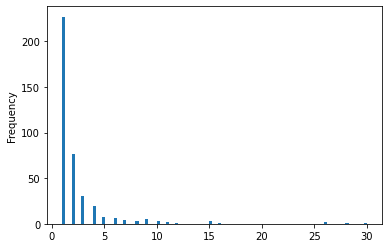

In [389]:
model_score.supp.plot.hist(bins=100)

In [390]:
model_score[model_score['acc'] < .5].sort_values('supp').tail(50)

,s,acc,supp
10,akropolis,0.000000,1
4,a6,0.000000,1
37,bolivia,0.000000,1
102,elektrische,0.000000,1
76,congo,0.000000,1
390,zuilen,0.000000,1
140,groot-brittannië,0.000000,1
141,grote markt,0.000000,1
131,gifu,0.000000,1
143,harley-davidson,0.000000,1


In [402]:
s = 'sint-maarten'
clf = models[s]


from sklearn.feature_extraction.text import HashingVectorizer
from eli5.sklearn import InvertableHashingVectorizer
y, text = zip(*surface_text[s])
e_label = {e:wm.id_to_titles(f'Q{e}')[0] if e != -1 else 'UNK' for e in clf.classes_}

ivec = InvertableHashingVectorizer(HashingVectorizer()).fit(text)

In [403]:
y_test, d_test = zip(*mewsli[mewsli[1].apply(lambda x: s in x)].apply(lambda x: (x[1][s], x[2]), axis=1))
labels = pd.Series(y_test).unique()
names = [wm.id_to_titles(f'Q{e}')[0] for e in labels]
from sklearn.metrics import classification_report
print(classification_report(y_test, clf.predict(ivec.transform(d_test)), 
                            labels=labels, target_names=names, zero_division=0))

                     precision    recall  f1-score   support

Sint_Maarten_(land)       0.00      0.00      0.00       3.0

          micro avg       0.00      0.00      0.00       3.0
          macro avg       0.00      0.00      0.00       3.0
       weighted avg       0.00      0.00      0.00       3.0



In [404]:
names = [wm.id_to_titles(f'Q{e}')[0] if e != -1 else 'UNK' for e in clf.classes_]
eli5.show_weights(clf, vec=ivec, top=20, target_names=names)

In [406]:
i = 1
print('Gold:', wm.id_to_titles(f'Q{y_test[i]}')[0])
display(d_test[i])

targets = set([clf.predict(ivec.transform([d_test[i]]))[0], y_test[i]])
eli5.show_prediction(clf, d_test[i], vec=ivec, target_names=names, targets = targets)

Gold: Sint_Maarten_(land)


'Sint Eustatius overweegt eis van autonomie bij het Internationale Gerechtshof  9 februari 2017\xa0  Sint Eustatius overweegt eis van autonomie bij het Internationale Gerechtshof  Coalitieleider Clyde van Putten (PLP) overweegt met zijn coalitie naar het Internationale Gerechtshof te stappen. Voor het hof denkt hij een autonome status af te kunnen dwingen voor Statia, zoals Sint Eustatius lokaal wordt genoemd.  Statiaanse politici hebben in de voorbije maanden bezoeken gebracht aan de Verenigde Naties in New York en gelobbyd bij Aruba, Curaçao en Sint-Maarten. De vorm van autonomie die Statia wil, gaat verder dan de autonomie van deze andere drie landen.  Begin januari tekende Van Putten officieel protest aan bij minister-president Mark Rutte. Die heeft hierop nog niet gereageerd. Van Putten en de Nederlandse regering verschillen van mening of de bewoners van Sint Eustatius ook daadwerkelijk autonomie willen. Het eilandsbestuur trekt zich op aan de uitslag van het referendum uit 2014. 

## Train from scratch

<AxesSubplot:>

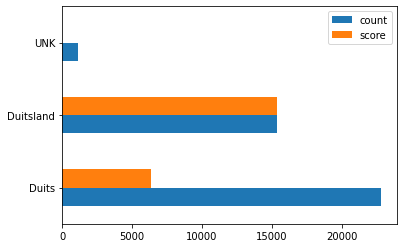

In [168]:
s = 'duits'

y, text = zip(*surface_text[s])
ec = scores[s]

import pandas as pd
y = pd.Series(y)
y[~y.isin(map(int,ec))] = -1
e_label = {e:wm.id_to_titles(f'Q{e}')[0] if e != -1 else 'UNK' for e in y.unique()}

pd.DataFrame({
    'count':{e_label[e]:c for e,c in y.value_counts().items()},
    'score':{e_label[int(e)]:c for e,c in ec.items()},
}).plot.barh()

In [169]:
def undersample(X, y, n, class_weight=None):
    if n < X.shape[0]:
        weights = None
        if class_weight == 'balanced':
            weights = pd.Series(y).replace(1 / pd.Series(y).value_counts())
        i = pd.DataFrame(range(X.shape[0])).sample(n=n, weights=weights)
        return X[i.index], np.array(y)[i.index]
    else:
        return X, y
    
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer(max_df=.5)
X = vec.fit_transform(text)

X, y = undersample(X, y, 1000)
print({e_label[e]:c for e,c in pd.Series(y).value_counts().items()})

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
clf = LogisticRegression(C=1000)
clf.fit(X, y)

{'Duits': 566, 'Duitsland': 392, 'UNK': 42}


/home/bbkruit/scratch/anaconda3/envs/takco2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=1000)

In [170]:
import eli5

eli5.show_weights(clf, vec=vec, top=20, target_names=[e_label[e] for e in clf.classes_])

In [174]:
mewsli = pd.read_csv('evaluation/Mewsli-9/nl.tsv', sep='\t', header=None)
mewsli[1] = mewsli[1].map(lambda x: {n:e for s,e in json.loads(x).items() for n in normalize(s)})
y_test, d_test = zip(*mewsli[mewsli[1].apply(lambda x: s in x)].apply(lambda x: (x[1][s], x[2]), axis=1))
display(d_test[0])

"Onderzoek: Waarom wordt Wikipedia gelezen?  300px|right 23 maart 2018\xa0  Wikipedia's missie is om educatieve inhoud te bieden en effectief te verspreiden. Om dit te doen is het nodig om te begrijpen waarom Wikipedia gelezen wordt. In dit artikel bespreken we wat we leerden over lezermotivatie dankzij een onderzoek dat in 14 talen werd uitgevoerd.  Waarom lees je dit artikel vandaag?  Dit is de vraag die we in juni 2017 aan lezers in 14 Wikipedia-talen stelden: Arabisch, Bengaals, Duits, Engels, Spaans, Hebreeuws, Hindi, Hongaars, Japans, Nederlands, Roemeens, Russisch, Oekraïens en Chinees. Met hulp van vrijwilligers op Wikipedia hebben we meer dan 215.000 reacties gekregen.  We hadden hierbij twee doelen in de gedachte: om taalfamiliebreed een beter begrip te krijgen van de behoefte, beweegredenen en kenmerken van de lezers, en om te verifiëren of de resultaten van een onderzoek uit 2016 op de Engelse Wikipedia nog steeds standhouden.  Waarom is het begrip van de behoefte van de le

In [185]:
clf.predict_proba(vec.transform(d_test[:1]))

array([[5.55078853e-04, 3.43277305e-04, 9.99101644e-01]])

In [187]:
print('Gold:', e_label[y_test[0]])
eli5.show_prediction(clf, d_test[0], vec=vec, target_names=[e_label[e] for e in clf.classes_])

Gold: Duits


In [180]:
eli5.show_prediction?

Signature: eli5.show_prediction(estimator, doc, **kwargs)
Docstring:
Return an explanation of estimator prediction
as an IPython.display.HTML object. Use this function
to show information about classifier prediction in IPython.

:func:`show_prediction` accepts all
:func:`eli5.explain_prediction` arguments and all
:func:`eli5.formatters.html.format_as_html`
keyword arguments, so it is possible to get explanation and
customize formatting in a single call.


If :func:`explain_prediction` returns an :class:`base.Explanation` object with
the ``image`` attribute not set to None, i.e. if explaining image based models,
then formatting is dispatched to an image display implementation, 
and image explanations are shown in an IPython cell.
Extra keyword arguments are passed to :func:`eli5.format_as_image`.

Note that this image display implementation 
requires ``matplotlib`` and ``Pillow`` as extra dependencies.
If the dependencies are missing, no formatting is done
and the original :class:`base.

<AxesSubplot:>

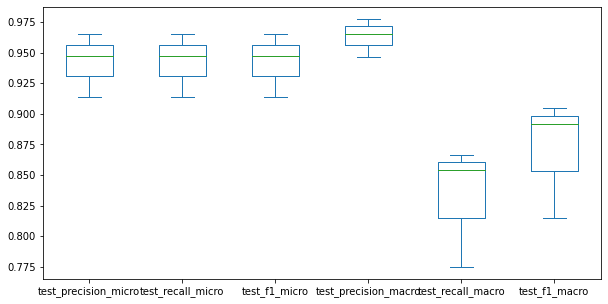

In [154]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

scoring = ('precision_micro', 'recall_micro', 'f1_micro', 'precision_macro', 'recall_macro', 'f1_macro')
cv_scores = cross_validate(
    LogisticRegression(C = clf.C_.mean()), X, y, cv=3,
    scoring=scoring,
    # return_train_score=True
)
cv_scores = pd.DataFrame(cv_scores)[['test_'+m for m in scoring]]
cv_scores.plot.box(figsize=(10,5))